In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

def build_model_deeper(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
unfit_df = pd.read_csv("../result/iou_2.csv")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df = train_df.reset_index()
train_unfit = pd.merge(unfit_df, train_df, on='id', how = 'left')
train_df = train_unfit
train_df = train_df.set_index('id')
train_df['unfit'] = (train_df['iou'] < 0.95) * 1 

In [5]:
len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
train_df['hassalt'] = train_df['masks'].apply(lambda x: (x.max()!=0) * 1)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
def get_splits(train_df, train_idx, val_idx):
    X_train = train_df.iloc[train_idx]
    X_valid = train_df.iloc[val_idx]
    x_train = np.array(X_train.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(X_valid.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    msk_train = np.array(X_train.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    msk_val = np.array(X_valid.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = X_train.hassalt.values
    y_valid = X_valid.hassalt.values
    id_train = X_train.index.values
    id_valid = X_valid.index.values
    return x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid

def argument(x_train, msk_train, y_train):
    aug_img = []
    aug_msk = []
    aug_y = []
    augments = [
        (1, HorizontalFlip(p=1)),
#         (1, VerticalFlip(p=1)),
#         (0.25, RandomRotate90(p=1)),
#         (0.25, Transpose(p=1)),
        (0.15, ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)),
        (0.15, GridDistortion(p=1)),
        (0.15, OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)),
#         (0.5, RandomSizedCrop(p=1, min_max_height=(int(img_size_ori / 2), img_size_ori), height=img_size_ori, width=img_size_ori)),
    ]

    for ratio, aug in tqdm_notebook(augments):
        selidx = np.random.choice(x_train.shape[0], int(x_train.shape[0] * ratio), replace=False)
        for idx in tqdm_notebook(selidx):
            augmented = aug(image=x_train[idx], mask=msk_train[idx])
            aimg = augmented['image']
            amsk = augmented['mask']
            if len(aimg.shape) < 3:
                aimg = aimg[...,np.newaxis]
            if len(amsk.shape) < 3:
                amsk = amsk[...,np.newaxis]
            aug_img.append(aimg)
            aug_msk.append(amsk)
            aug_y.append(y_train[idx])

    aug_img = np.asarray(aug_img)
    aug_msk = np.asarray(aug_msk)
    aug_y = np.asarray(aug_y)
    x_train = np.append(x_train, aug_img, axis=0)
    msk_train = np.append(msk_train, aug_msk, axis=0)
    y_train = np.append(y_train, aug_y, axis=0)
    print(x_train.shape)
    print(msk_train.shape)
    print(y_train.shape)
    
    return x_train, msk_train, y_train

In [7]:
def train_model(fold, x_train, y_train, x_valid, y_valid, id_valid):
    start_feature = 32
    batch_size = 32
    dropout = 0.5
    
    cur_base_name = 'Unet_resnet_deeper_fix10_{}_{}_{}_{}'.format(start_feature, batch_size, dropout, fold)
    cur_save_model_name = '../model/segmenter/{}.model'.format(cur_base_name)
    if False:# os.path.exists(cur_save_model_name):
        print('load from continue', cur_save_model_name)
        model = load_model(cur_save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
    else:
    
        base_name = 'Unet_resnet_deeper_fix7_{}_{}_{}_{}'.format(start_feature, batch_size, dropout, fold)
        save_model_name = '../model/segmenter/{}.model'.format(base_name)
        submission_dir = '../result/segmenter/{}.csv'.format(base_name)
        oof_dir = '../result/segmenter_oof/{}'.format(base_name)

        print('load from last run', save_model_name)
        model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                       'lovasz_loss': lovasz_loss})
    
    base_name = 'Unet_resnet_deeper_fix10_{}_{}_{}_{}'.format(start_feature, batch_size, dropout, fold)
    save_model_name = '../model/segmenter/{}.model'.format(base_name)
    submission_dir = '../result/segmenter/{}.csv'.format(base_name)
    oof_dir = '../result/segmenter_oof/{}'.format(base_name)
    
    c = optimizers.adam(lr = 0.0025)
#     c = optimizers.SGD(lr = 0.01, momentum=0.9, decay=0.0001)
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

    #model.summary()
    board = keras.callbacks.TensorBoard(log_dir='log/segmenter/{}'.format(base_name),
                           histogram_freq=0, write_graph=True, write_images=False)
    early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=12, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                       mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)
    epochs = 200

    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                        verbose=1)
    

In [8]:
folds = [0,1,2,3,4]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    if fold not in folds:
        print('skip fold', fold)
        continue
    
    print('fold', fold)
    x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid = get_splits(train_df, train_idx, val_idx)
    x_train, msk_train, y_train = argument(x_train, msk_train, y_train)
    
    model = train_model(fold, x_train, msk_train, x_valid, msk_val, id_valid)
    
    from keras import backend as K
    K.clear_session()

fold 0



(7835, 101, 101, 1)
(7835, 101, 101, 1)
(7835,)
load from last run ../model/segmenter/Unet_resnet_deeper_fix7_32_32_0.5_0.model
Train on 7835 samples, validate on 801 samples
Epoch 1/200
7835/7835 [==============================] - 164s 21ms/step - loss: -0.5536 - my_iou_metric_2: 0.8637 - val_loss: -0.6875 - val_my_iou_metric_2: 0.8966

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.89663, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_0.model
Epoch 2/200
7835/7835 [==============================] - 151s 19ms/step - loss: -0.5600 - my_iou_metric_2: 0.8662 - val_loss: -0.6964 - val_my_iou_metric_2: 0.8978

Epoch 00002: val_my_iou_metric_2 improved from 0.89663 to 0.89775, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_0.model
Epoch 3/200
7835/7835 [==============================] - 151s 19ms/step - loss: -0.5778 - my_iou_metric_2: 0.8678 - val_loss: -0.6863 - val_my_iou_metric_2: 0.8930

Epoch 00003: val_my_iou_metric_2 did not i


(7835, 101, 101, 1)
(7835, 101, 101, 1)
(7835,)
load from last run ../model/segmenter/Unet_resnet_deeper_fix7_32_32_0.5_1.model
Train on 7835 samples, validate on 801 samples
Epoch 1/200
7835/7835 [==============================] - 162s 21ms/step - loss: -0.5543 - my_iou_metric_2: 0.8656 - val_loss: -0.7186 - val_my_iou_metric_2: 0.9066

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.90662, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_1.model
Epoch 2/200
7835/7835 [==============================] - 151s 19ms/step - loss: -0.5765 - my_iou_metric_2: 0.8688 - val_loss: -0.7093 - val_my_iou_metric_2: 0.9062

Epoch 00002: val_my_iou_metric_2 did not improve from 0.90662
Epoch 3/200
7835/7835 [==============================] - 151s 19ms/step - loss: -0.5778 - my_iou_metric_2: 0.8688 - val_loss: -0.7072 - val_my_iou_metric_2: 0.9039

Epoch 00003: val_my_iou_metric_2 did not improve from 0.90662
Epoch 4/200
7835/7835 [==============================] - 151s 1

7835/7835 [==============================] - 152s 19ms/step - loss: -0.6423 - my_iou_metric_2: 0.8816 - val_loss: -0.7204 - val_my_iou_metric_2: 0.9079

Epoch 00032: val_my_iou_metric_2 did not improve from 0.91036

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 33/200
7835/7835 [==============================] - 152s 19ms/step - loss: -0.6483 - my_iou_metric_2: 0.8827 - val_loss: -0.7200 - val_my_iou_metric_2: 0.9091

Epoch 00033: val_my_iou_metric_2 did not improve from 0.91036
Epoch 34/200
7835/7835 [==============================] - 152s 19ms/step - loss: -0.6444 - my_iou_metric_2: 0.8821 - val_loss: -0.7204 - val_my_iou_metric_2: 0.9076

Epoch 00034: val_my_iou_metric_2 did not improve from 0.91036
Epoch 35/200
7835/7835 [==============================] - 152s 19ms/step - loss: -0.6492 - my_iou_metric_2: 0.8830 - val_loss: -0.7207 - val_my_iou_metric_2: 0.9071

Epoch 00035: val_my_iou_metric_2 did not improve from 0.91036

Epoch 00035: Reduc


(7840, 101, 101, 1)
(7840, 101, 101, 1)
(7840,)
load from last run ../model/segmenter/Unet_resnet_deeper_fix7_32_32_0.5_2.model
Train on 7840 samples, validate on 800 samples
Epoch 1/200
7840/7840 [==============================] - 163s 21ms/step - loss: -0.5273 - my_iou_metric_2: 0.8607 - val_loss: -0.6630 - val_my_iou_metric_2: 0.8947

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.89475, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_2.model
Epoch 2/200
7840/7840 [==============================] - 152s 19ms/step - loss: -0.5504 - my_iou_metric_2: 0.8659 - val_loss: -0.6415 - val_my_iou_metric_2: 0.8930

Epoch 00002: val_my_iou_metric_2 did not improve from 0.89475
Epoch 3/200
7840/7840 [==============================] - 152s 19ms/step - loss: -0.5578 - my_iou_metric_2: 0.8654 - val_loss: -0.6584 - val_my_iou_metric_2: 0.8959

Epoch 00003: val_my_iou_metric_2 improved from 0.89475 to 0.89587, saving model to ../model/segmenter/Unet_resnet_deeper_fix1


(7842, 101, 101, 1)
(7842, 101, 101, 1)
(7842,)
load from last run ../model/segmenter/Unet_resnet_deeper_fix7_32_32_0.5_3.model
Train on 7842 samples, validate on 799 samples
Epoch 1/200
7842/7842 [==============================] - 163s 21ms/step - loss: -0.5645 - my_iou_metric_2: 0.8701 - val_loss: -0.6770 - val_my_iou_metric_2: 0.8909

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.89086, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_3.model
Epoch 2/200
7842/7842 [==============================] - 152s 19ms/step - loss: -0.5782 - my_iou_metric_2: 0.8698 - val_loss: -0.6759 - val_my_iou_metric_2: 0.8874

Epoch 00002: val_my_iou_metric_2 did not improve from 0.89086
Epoch 3/200
7842/7842 [==============================] - 152s 19ms/step - loss: -0.5669 - my_iou_metric_2: 0.8680 - val_loss: -0.6685 - val_my_iou_metric_2: 0.8875

Epoch 00003: val_my_iou_metric_2 did not improve from 0.89086
Epoch 4/200
7842/7842 [==============================] - 152s 1


(7842, 101, 101, 1)
(7842, 101, 101, 1)
(7842,)
load from last run ../model/segmenter/Unet_resnet_deeper_fix7_32_32_0.5_4.model
Train on 7842 samples, validate on 799 samples
Epoch 1/200
7842/7842 [==============================] - 163s 21ms/step - loss: -0.5383 - my_iou_metric_2: 0.8614 - val_loss: -0.6926 - val_my_iou_metric_2: 0.8989

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.89887, saving model to ../model/segmenter/Unet_resnet_deeper_fix10_32_32_0.5_4.model
Epoch 2/200
7842/7842 [==============================] - 152s 19ms/step - loss: -0.5574 - my_iou_metric_2: 0.8651 - val_loss: -0.6890 - val_my_iou_metric_2: 0.8971

Epoch 00002: val_my_iou_metric_2 did not improve from 0.89887
Epoch 3/200
7842/7842 [==============================] - 152s 19ms/step - loss: -0.5562 - my_iou_metric_2: 0.8630 - val_loss: -0.6861 - val_my_iou_metric_2: 0.8969

Epoch 00003: val_my_iou_metric_2 did not improve from 0.89887
Epoch 4/200
7842/7842 [==============================] - 152s 1

In [9]:
pred_vals = []
msk_vals = []
pred_tests = []
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    print('predict for fold', fold)
    
    start_feature = 32
    batch_size = 32
    dropout = 0.5
    base_name = 'Unet_resnet_deeper_fix10_{}_{}_{}_{}'.format(start_feature, batch_size, dropout, fold)
    basic_name = '../model/segmenter/{}'.format(base_name)
    save_model_name = basic_name + '.model'

    model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
    
    x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid = get_splits(train_df, train_idx, 
                                                                                            val_idx)
    
    preds_valid = predict_result(model,x_valid,img_size_target)
    pred_vals.append(preds_valid)
    msk_vals.append(msk_val)
    
    preds_test = predict_result(model,x_test,img_size_target)
    pred_tests.append(preds_test)

    from keras import backend as K
    K.clear_session()

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



predict for fold 0
18000/18000 [==============================] - 63s 3ms/step
predict for fold 1
18000/18000 [==============================] - 63s 3ms/step
predict for fold 2
18000/18000 [==============================] - 63s 3ms/step
predict for fold 3
18000/18000 [==============================] - 63s 3ms/step
predict for fold 4
18000/18000 [==============================] - 63s 3ms/step



[0.89615  0.897    0.897575 0.897775 0.897875 0.898225 0.898525 0.898875
 0.8994   0.899425 0.899525 0.899675 0.8999   0.900075 0.90005  0.900225
 0.900375 0.901425 0.9005   0.900375 0.900175 0.899875 0.89965  0.89925
 0.8989   0.898825 0.898375 0.898625 0.89825  0.897825 0.8975   0.897125
 0.896675 0.896275 0.895825]


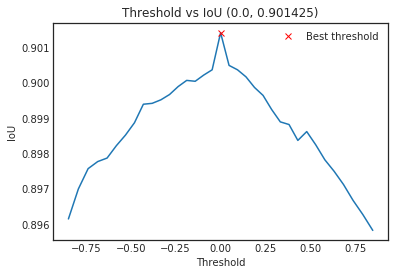

In [10]:
val_ids = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    val_ids += list(train_df.iloc[val_idx].index.values)
    
pred_all = np.concatenate(pred_vals, axis=0)
msk_all = np.concatenate(msk_vals, axis= 0)

thresholds_ori = np.linspace(0.3, 0.7, 35)
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(msk_all, pred_all > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
title = "Threshold vs IoU ({}, {})".format(threshold_best, iou_best)
print(title)
plt.title(title)
plt.legend()



In [11]:
val_all = (pred_all > threshold_best) * 1
df_iou = pd.DataFrame(columns=['id', 'iou'])
cnt = 0
for i in tqdm_notebook(range(len(val_all))):
    id = val_ids[i]
    iou = iou_metric_batch(msk_all[i], val_all[i])
    df_iou = df_iou.append({'id':id, 'iou':iou}, ignore_index=True)

df_iou.to_csv('../result/iou_2.csv', index = False)

In [12]:
pred_tests_act = pred_tests
pred_test_all = np.zeros_like(pred_tests_act[0], dtype=np.float32)
for pre in pred_tests_act:
    pred_test_all += pre / len(pred_tests_act)
    
pred_dict = {idx: rle_encode(np.round(downsample(pred_test_all[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/segmenter/unet_fix10_avg.csv', 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)


save result
upload result
cmd: kaggle competitions submit -c tgs-salt-identification-challenge -f ../result/segmenter/unet_fix10_avg.csv.7z -m "submit"
